### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-59fc971d-5208-c4e2-f1a1-5bf38387a523)


In [2]:
!pip install daam
!pip install accelerate  # this is to reduce CPU model load overhead
!pip install stanza # for stanford pos tagger
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.1/453.1 KB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━

### Load Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [3]:
import os
import json
import datetime
from tqdm import tqdm
import base64
import IPython
import random
import requests
from io import BytesIO
from math import trunc

from matplotlib import pyplot as plt
import numpy as np

from PIL import Image
from PIL import ImageDraw as PILImageDraw
import cv2

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag 

from diffusers import StableDiffusionPipeline
import daam
import torch
import clip

from pycocotools.coco import COCO

Download the stopwords for removing stopwords

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
import stanza
stanza.download('en')

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


### Load Data

The below list is a placeholder for any list of prompts, we will be replacing it with a list of prompts from `MS-COCO` text annotations later.

In [6]:
# prompts = [
#   "A group of people stand in the back of trucks filled with cotton.",
#   "A mother and three children collecting garbage from a blue and white garbage can on the street.",
#   "A woman is sitting in a chair reading a book with her head resting on her free hand.",
#   "A brown and white dog exiting a yellow and blue ramp in a grassy area.",
#   "A boy stands on a rocky mountain."
#   ]

prompts = [
  "A boy stands on a rocky mountain."
]

Cleaning the prompts. I adopt few ways to clean the prompt:
- Tokenization
- Remove stop words
- Remove non-alphabets
- Keep only nouns
- Lemmatization (to store the object name)

In [7]:
# loads the text processing pipeline
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

# treebank-specific POS (XPOS) tags to keep, other POS tagged tokens will not be retained
keep_pos_tags = ['NN', 'NNS', 'NNP', 'NNPS']

# Stopwords
stpwords = set(stopwords.words('english'))

# extract parts of speech
def extract_pos(doc):
  parsed_text = list()
  for sent in doc.sentences:
    for wrd in sent.words:
      parsed_text.append((wrd.text, wrd.xpos))
  return parsed_text

# extract lemma
def extract_lemma(doc):
  parsed_text = list()
  for sent in doc.sentences:
    for wrd in sent.words:
      # extract text and lemma
      parsed_text.append((wrd.text, wrd.lemma))
  # return a dataframe
  return parsed_text

def clean_prompt(prompt):
  # tokenizes, lemmatizes and pos tags the prompt
  processed_prompt = nlp(prompt.lower())
  
  # extracts pos tags from the processed_prompt
  pos_tagged_prompt = extract_pos(processed_prompt)

  # lemmatized text
  lemmatized_prompt = extract_lemma(processed_prompt)

  # keep only the noun words, removes stopwords
  fin_prompt = [word for word, pos_tag in pos_tagged_prompt if ((pos_tag in keep_pos_tags) and (word not in stpwords))]
  obj_prompt = [word_lemma[1] for word_pos, word_lemma in zip(pos_tagged_prompt, lemmatized_prompt) if ((word_pos[1] in keep_pos_tags) and (word_lemma[0] not in stpwords))]
  return fin_prompt, obj_prompt

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


An example is shown below for the application of `clean_prompt`.

In [8]:
clean_prompt("The fishes are playing in the mountains.")

(['fishes', 'mountains'], ['fish', 'mountain'])

In [9]:
clean_prompt('Chicken, Barley and Mushroom Soup - 4 Ww Pts. celery, carrots, onions, celery. carrots. onions, celery, carrots, onions, celery, carrots, onions,')

(['chicken',
  'barley',
  'mushroom',
  'soup',
  'ww',
  'pts.',
  'celery',
  'carrots',
  'onions',
  'celery',
  'carrots',
  'onions',
  'celery',
  'carrots',
  'onions',
  'celery',
  'carrots',
  'onions'],
 ['chicken',
  'barley',
  'mushroom',
  'soup',
  'ww',
  'pts.',
  'celery',
  'carrot',
  'onion',
  'celery',
  'carrot',
  'onion',
  'celery',
  'carrot',
  'onion',
  'celery',
  'carrot',
  'onion'])

### Setting up the Pipeline

#### Brief Overview of the Storage Scheme of the Generated Data

I will set up the pipeline for generation of the heatmaps and bounding boxes for each generated image for each prompt in the `prompts` list. We will be generating `NUM_IMAGES_PER_PROMPT` images per prompt.

Every output by our code will be stored in `Data-Generated` folder.

I use `COCO` Dataset format to store the bboxes and segmentation for each image.

#### Set some parameters

In [10]:
DEVICE = 'cuda' # device
NUM_IMAGES_PER_PROMPT = 4 # Number of images to be generated per prompt
NUM_INFERENCE_STEPS = 50 # Number of inference steps to the Diffusion Model
NAME_OF_DATASET = 'COCO Stable Diffusion 2 Dataset' # Name of the generated dataset
SAVE_AFTER_NUM_IMAGES = 5 # Number of images after which the annotation and caption files will be saved
NMS_OVERLAP_THRESHOLD = 0.5 # Non-Max Suppression Threshold
BLUR_KERNEL_SIZE = (5, 5) # The size of the kernel to be used for blurring the heatmap before binary thresholding
SMALL_SEGMENT_THRESH = 30 # For filtering small segments, higher the threshold more smaller segments will be allowed (Within a bbox operation for each category in an image)
SMALL_BOX_THRESH = 30 # For filtering small boxes, higher the threshold more small boxes will be allowed (Between bboxes operation for each category in an image)

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [11]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Setting up the folder structure to generate the data and the dataset information for storing annotations and captions in `COCO` format.

In [12]:
# The folder that will contain the generated data
os.mkdir('Data-Generated') # Stores everything that is generated
os.mkdir('Data-Generated/images') # Stores generated images
os.mkdir('Data-Generated/annotations') # Stores Annotations
os.mkdir('Data-Generated/captions') # Stores Captions

info = { # Info about the dataset
    "description": NAME_OF_DATASET,
    "url": "https://github.com/RishiDarkDevil/Text-Based-Object-Discovery",
    "version": "1.0",
    "year": 2022,
    "contributor": "Rishi Dey Chowdhury (RishiDarkDevil)",
    "date_created": "2022"
}

licenses = [{ # Licenses associated with the dataset
    'url': 'https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL',
    'id': 1,
    'name': 'CreativeML Open RAIL++-M License'
}]

images = list() # Stores the generated image info
annotations = list() # Stores the annotation info
categories = list() # Stores the category info
captions = list() # Stores the captions info
cat2id = dict() # Stores the category to id mapping
cat_id = 1 # Assigns id to categories as we go on adding categories which we discover
image_id = 1 # Assigns generated image ids
annotation_id = 1 # Assigns annotations annotation ids
caption_id = 1 # Assigns captions caption ids
save_idx = 1 # The index which stores how many times we saved the json file before

Let's generate Global Word Attribution HeatMaps.

In [13]:
class NpEncoder(json.JSONEncoder): # To help encode the unsupported datatypes to json serializable format
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return json.JSONEncoder.default(self, obj)

def save(): # Saving annotations and captions when called -- mainly to avoid code repetition
  # Serializing json
  json_obj_det = json.dumps({
      'info': info,
      'licenses': licenses,
      'images': images,
      'annotations': annotations,
      'categories': categories
  }, indent=4, cls=NpEncoder)

  # Writing json
  with open(f"Data-Generated/annotations/object_detect-{save_idx}.json", "w") as outfile:
    outfile.write(json_obj_det)

  print('Saved Annotations')

  # Delete json from python env
  del json_obj_det

  # Serializing json
  json_obj_cap = json.dumps({
      'info': info,
      'licenses': licenses,
      'images': images,
      'annotations': captions,
  }, indent=4, cls=NpEncoder)

  # Writing json
  with open(f"Data-Generated/captions/object_caption-{save_idx}.json", "w") as outfile:
    outfile.write(json_obj_cap)

  # Delete json from python env
  del json_obj_cap

  # Clearing out all the lists except cat2id to maintaining the unique category ids assigned to each new object
  images.clear()
  annotations.clear()
  categories.clear()
  captions.clear()

In [14]:
# Helper Function that performs Non-Max Suppression when given the bounding boxes and threshold
# We merge multiple boxes together using Non-Max Suppression with a modification. Since, each box is corresponding to a segment. Now, when we delete boxes, we keep track 
# which box it is merged to. Now, if we use the boundary of this box as a boundary for the object there would be segments spreading out of the box. So, instead I enlarge the 
# box to the extreme segment which merged to this box by NMS 
# Greatly reduces too many bounding boxes.
def non_max_suppression_fast(boxes, overlapThresh):
  # if there are no boxes, return an empty list
  if len(boxes) == 0:
    return []
  # if the bounding boxes integers, convert them to floats --
  # this is important since we'll be doing a bunch of divisions
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
  # initialize the list of picked indexes	
  pick = []
  pick2idx = dict()
  # grab the coordinates of the bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  # compute the area of the bounding boxes and sort the bounding
  # boxes by the bottom-right y-coordinate of the bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
  # keep looping while some indexes still remain in the indexes
  # list
  while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    # find the largest (x, y) coordinates for the start of
    # the bounding box and the smallest (x, y) coordinates
    # for the end of the bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    # compute the ratio of overlap
    overlap = (w * h) / area[idxs[:last]]
    # delete all indexes from the index list that have
    to_delete = np.concatenate(([last], np.where(overlap >= overlapThresh)[0]))
    idxs = np.delete(idxs, to_delete)
    # the boxes to be deleted are mapped to a box so the box to which it is mapped
    # should also be in the dictionary else it will be omitted all together
    pick2idx[i] = list(to_delete) + [i]

  # return only the bounding box idx that were picked
  return pick, pick2idx

In [15]:
try:
  # Iterating overs the prompts
  for i, prompt in enumerate(prompts):

    # Flashing some details
    print()
    print(f'Prompt No. {i+1}/{len(prompts)}')
    print('Prompt:', prompt)
    cleaned_prompt, object_prompt = clean_prompt(prompt)
    print('Cleaned Prompt:', ' '.join(cleaned_prompt))
    print('Objects:', ' '.join(object_prompt))
    print('Generating Image...')

    try:
      # Stores the new objects found in this prompt
      new_words = list()
      # Updating Categories using cleaned prompt if required and assigning index
      for ind, word in enumerate(object_prompt):
        if word not in cat2id:
          new_words.append(word)
          cat2id[word] = cat_id
          categories.append({"supercategory": '', "id": cat_id, "name": word}) ### FIX SUPERCATEGORY
          cat_id += 1

      for j in range(NUM_IMAGES_PER_PROMPT):

        # Generating images and storing their trace for daam output
        with daam.trace(model) as trc:
          output_image = model(prompt, num_inference_steps=NUM_INFERENCE_STEPS).images[0]
          global_heat_map = trc.compute_global_heat_map()

        # Saving generated Image
        output_image.save(f'Data-Generated/images/{i}_{j}.png')
        print(f'Saving generated Image as.. {i}_{j}.png')

        width, height = output_image.size
        # Image details
        image_det = {
            'license': 1,
            'file_name': f'{i}_{j}.png',
            'height': height,
            'width': width,
            'date_captured': datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
            'id': image_id
        }
        images.append(image_det)

        # Captions details
        cap_det = {
            'id': caption_id,
            'image_id': image_id,
            'caption': prompt
        }
        captions.append(cap_det)

        print(f'Generating Annotations for {i}_{j}.png')
        # Generate Global Word Attribution HeatMap
        for word, obj in tqdm(zip(cleaned_prompt, object_prompt)):

          # word category id
          word_cat_id = cat2id[obj]
          
          # Compute heatmap for a non-stopword
          word_heatmap = global_heat_map.compute_word_heat_map(word).expand_as(output_image).numpy()

          # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
          heatmap = np.array(word_heatmap * 255, dtype = np.uint8)

          # Blur the heatmap for better thresholding
          blurred_heatmap = cv2.GaussianBlur(heatmap, BLUR_KERNEL_SIZE, 0)

          # Binary threshold of the above heatmap - serves as sort of semantic segmentation for the word
          thresh = cv2.threshold(heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

          # Find contours from the binary threshold
          cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cnts = cnts[0] if len(cnts) == 2 else cnts[1]

          if len(cnts) == 0: # If no contours detected skip
            continue

          # Find bounding boxes from contours
          bboxes = np.zeros((len(cnts), 4))

          for idx, c in enumerate(cnts):
            x,y,w,h = cv2.boundingRect(c)
            bboxes[idx, :] = np.array([x,y, x+w, y+h])
          
          # Merge multiple box predictions using Non-Max Suppression
          picks, picks2idx = non_max_suppression_fast(bboxes, NMS_OVERLAP_THRESHOLD)
          
          # stores filtered out boxes i.e. small boxes removed
          curr_word_annots = list()

          # Annotating the segmentation and the bounding boxes
          for pick in picks:
            # All segments in current pick
            segments = [list(cnts[k].squeeze().reshape(1, -1).squeeze()) for k in picks2idx[pick]]

            # Area of each segment in segments
            all_areas = [cv2.contourArea(cnts[k]) for k in picks2idx[pick]]

            # Finding discard threshold for small segments for current category in current image (Within pick small segment filtration)
            curr_pick_seg_small_filter = np.max(all_areas) / SMALL_SEGMENT_THRESH
            
            # stores the filtered out segments
            filtered_segments = list()

            # Filtering small segments in current pick for current word/object
            for seg_idx, ar in enumerate(all_areas):
              if ar >= curr_pick_seg_small_filter:
                filtered_segments.append(segments[seg_idx])

            # The area inside one annotation is sum of the area of all the segments that form it
            area = np.sum(all_areas)

            # Finding bounding box location and dimensions based on filtered segments
            x_segments = [x for segment in filtered_segments for x in segment[::2]]
            y_segments = [y for segment in filtered_segments for y in segment[1::2]]
            x = min(x_segments)
            y = min(y_segments)
            w = max(x_segments) - x
            h = max(y_segments) - y

            ann_det = { # Annotation details
                'segmentation': filtered_segments,
                'area': area,
                'iscrowd': 0,
                'image_id': image_id,
                'bbox': [x, y, w, h],
                'category_id': word_cat_id,
                'id': annotation_id,
            }
            annotation_id += 1
            curr_word_annots.append(ann_det)
          
          # Finding discard threshold for small boxes for current category in current image (Between picks small box filtration)
          curr_word_ann_small_filter = np.max([ann['area'] for ann in curr_word_annots]) / SMALL_BOX_THRESH
          
          # Filtering small box annotations for current word/object
          for ann_det in curr_word_annots:
            if ann_det['area'] >= curr_word_ann_small_filter:
              annotations.append(ann_det)
        
        print()
        print('Generated Annotations.')
        
        # Saving Annotations and Captions
        if image_id % SAVE_AFTER_NUM_IMAGES == 0:
          save()
          print(f'Annotations and Captions saved... object_detect-{save_idx}.json and object_caption-{save_idx}.json')

          save_idx += 1

        image_id += 1

        caption_id += 1

    except Exception as e: # In case some prompt creates any error just skip it!
      print()
      print('Error Message:', e)
      print('Skipping Current Prompt...')

      # Undoing the changes in case we skip the prompt
      # Observe if an exception happen then it can only happen in the Generate Global Word Attribution HeatMap Section
      # Assuming that Stable Diffusion with output atleast something for each prompt
      # So if an exception happens in the above mentioned section then by then we have appended some things which we undo below
      rmv_count = len(new_words)

      # Deleting the new words which are detected on this prompt in case we deal with exception
      for del_word in new_words:
        cat2id.pop(del_word, None)
      
      # Delete the new categories we added
      for _ in range(rmv_count):
        categories.pop()
      
      # Delete the image generated
      images.pop()

      # Delete the caption for this image
      captions.pop()

      # Fix category id
      cat_id -= rmv_count
      
      continue

  if ((image_id-1) % SAVE_AFTER_NUM_IMAGES != 0 and image_id > 1) or image_id == 1:
    save()

except KeyboardInterrupt: # In case of KeyboardInterrupt save the annotations and captions
  save()


Prompt No. 1/1
Prompt: A boy stands on a rocky mountain.
Cleaned Prompt: boy mountain
Objects: boy mountain
Generating Image...


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 0_0.png
Generating Annotations for 0_0.png


2it [00:00, 16.73it/s]


Generated Annotations.


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 0_1.png
Generating Annotations for 0_1.png


2it [00:00, 246.88it/s]


Generated Annotations.


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 0_2.png
Generating Annotations for 0_2.png


2it [00:00, 129.61it/s]


Generated Annotations.


  0%|          | 0/51 [00:00<?, ?it/s]

Saving generated Image as.. 0_3.png
Generating Annotations for 0_3.png


2it [00:00, 99.85it/s]


Generated Annotations.
Saved Annotations


In case we generate multiple annotation files we will have to merge them together into a single json file. The following cell does just that and results into a single `annotations.json`.

In [16]:
print('Starting Annotation Files Merge...')
# Annotation File Names present in the annotations directory
ann_file_names = os.listdir('Data-Generated/annotations')
print('Number of Annotation Files found:', len(ann_file_names))
print('Annotation Files found:', ' '.join(ann_file_names))
ann_files = list() # Contains the list of loaded annotation json files
for ann_file_name in tqdm(ann_file_names): # Loads the annotation json files and appens to ann_files
  with open(os.path.join('Data-Generated/annotations', ann_file_name)) as json_file:
    ann_file = json.load(json_file)
    ann_files.append(ann_file)
# Creating the single annotation file
annotation_file = {
    'info': ann_files[0]['info'],
    'licenses': ann_files[0]['licenses'],
    'images': [image for ann_file in ann_files for image in ann_file['images']],
    'annotations': [ann for ann_file in ann_files for ann in ann_file['annotations']],
    'categories': [cat for ann_file in ann_files for cat in ann_file['categories']]
}
# Serializing json
ann_json_file = json.dumps(annotation_file, indent=4)
# Writing json
with open(f"Data-Generated/annotations/annotations.json", "w") as outfile:
  outfile.write(ann_json_file)
print()
print('Saved Annotation file... annotations.json')
# UNCOMMENT IF YOU WISH TO REMOVE ALL THE ANNOTATION FILES EXCEPT ONE BIG ANNOTATION FILE
# print('Removing the annotation files other than annotations.json')
# for ann_file_name in ann_file_names:
#   os.remove(os.path.join('Data-Generated/annotations', ann_file_name))
print('A successful merge!')

Starting Annotation Files Merge...
Number of Annotation Files found: 1
Annotation Files found: object_detect-1.json


100%|██████████| 1/1 [00:00<00:00, 146.90it/s]


Saved Annotation file... annotations.json
A successful merge!


In case we generate multiple caption files we will have to merge them together into a single json file. The following cell does just that and results into a single `captions.json`.

In [17]:
print('Starting Caption Files Merge...')
# Caption File Names present in the captions directory
cap_file_names = os.listdir('Data-Generated/captions')
print('Number of Caption Files found:', len(cap_file_names))
print('Caption Files found:', ' '.join(cap_file_names))
cap_files = list() # Contains the list of loaded caption json files
for cap_file_name in tqdm(cap_file_names): # Loads the caption json files and appens to cap_files
  with open(os.path.join('Data-Generated/captions', cap_file_name)) as json_file:
    cap_file = json.load(json_file)
    cap_files.append(cap_file)
# Creating the single caption file
caption_file = {
    'info': cap_files[0]['info'],
    'licenses': cap_files[0]['licenses'],
    'images': [image for cap_file in cap_files for image in cap_file['images']],
    'annotations': [ann for cap_file in cap_files for ann in cap_file['annotations']],
}
# Serializing json
cap_json_file = json.dumps(caption_file, indent=4)
# Writing json
with open(f"Data-Generated/captions/captions.json", "w") as outfile:
  outfile.write(cap_json_file)
print()
print('Saved Caption file... captions.json')
# UNCOMMENT IF YOU WISH TO REMOVE ALL THE CAPTION FILES EXCEPT ONE BIG CAPTION FILE
# print('Removing the caption files other than captions.json')
# for cap_file_name in cap_file_names:
#   os.remove(os.path.join('Data-Generated/captions', cap_file_name))
print('A successful merge!')

Starting Caption Files Merge...
Number of Caption Files found: 1
Caption Files found: object_caption-1.json


100%|██████████| 1/1 [00:00<00:00, 3542.49it/s]


Saved Caption file... captions.json
A successful merge!


To download the folder containing all the generated data.

In [18]:
# UNCOMMENT DOWNLOAD THE GENERATED DATA FOLDER
# !zip -r /content/file.zip /content/Data-Generated
# from google.colab import files
# files.download("/content/file.zip")

If in case you need to delete the `Data-Generated` folder with all its contents.

In [19]:
# # UNCOMMENT IF NEEDED
# import shutil
# shutil.rmtree('Data-Generated')

### Visualization of DAAM related outputs

Now that I have generated the images for the prompts and annotated each image with the segmentations and bounding boxes. Let's visualize stuffs.

In [20]:
# from directory_tree import display_tree
# display_tree('Data-Generated')

Set the `annotation_path`, `caption_path` and `image_dir` below.

In [21]:
annotation_path = r'Data-Generated/annotations/annotations.json'
caption_path = r'Data-Generated/captions/captions.json'
image_dir = r'Data-Generated/images'

In [22]:
coco_annotation = COCO(annotation_file=annotation_path)
coco_caption = COCO(annotation_file=caption_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Below we visualize our synthetic annotated dataset. We now can exploit the benefit of using COCO dataset format, i.e. COCO utility functions for visualizing the results.

In [23]:
def visualize_annotation(image_id, figsize = (20,10)):
  # Load Image Details corresponding to the image_id
  img_info = coco_annotation.loadImgs([image_id])[0]
  img_file_name = img_info['file_name']
  # Load Annotation Details corresponding to the image_id
  ann_ids = coco_annotation.getAnnIds(imgIds=[image_id], iscrowd=None)
  cap_ids = coco_caption.getAnnIds(imgIds=[image_id])
  anns = coco_annotation.loadAnns(ann_ids)
  cap = coco_caption.loadAnns(cap_ids)
  # Load Image corresponding to the image_id
  im = Image.open(os.path.join(image_dir, img_file_name))
  # Plot and visualize results
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  ax[0].axis('off')
  ax[1].axis('off')
  ax[0].imshow(np.asarray(im))
  ax[1].imshow(np.asarray(im))
  coco_annotation.showAnns(anns, draw_bbox=True)
  ann_names = [coco_annotation.loadCats(ann['category_id'])[0]['name'] for ann in anns]
  for i, ann in enumerate(anns):
    ax[1].text(anns[i]['bbox'][0], anns[i]['bbox'][1], ann_names[i], style='italic', 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
  fig.suptitle(cap[0]['caption'])
  plt.show()

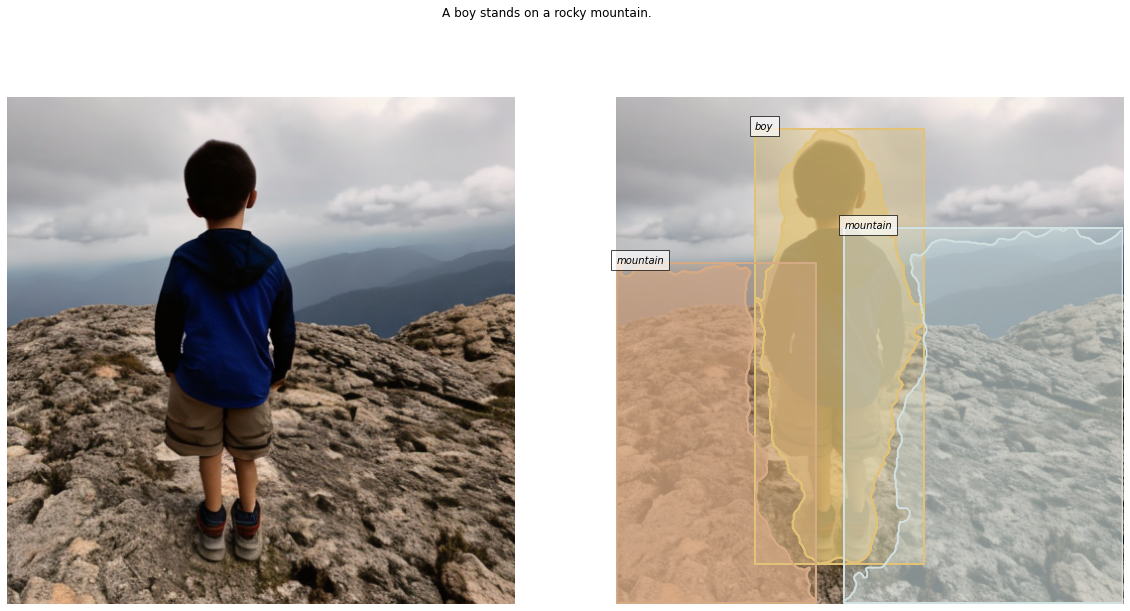

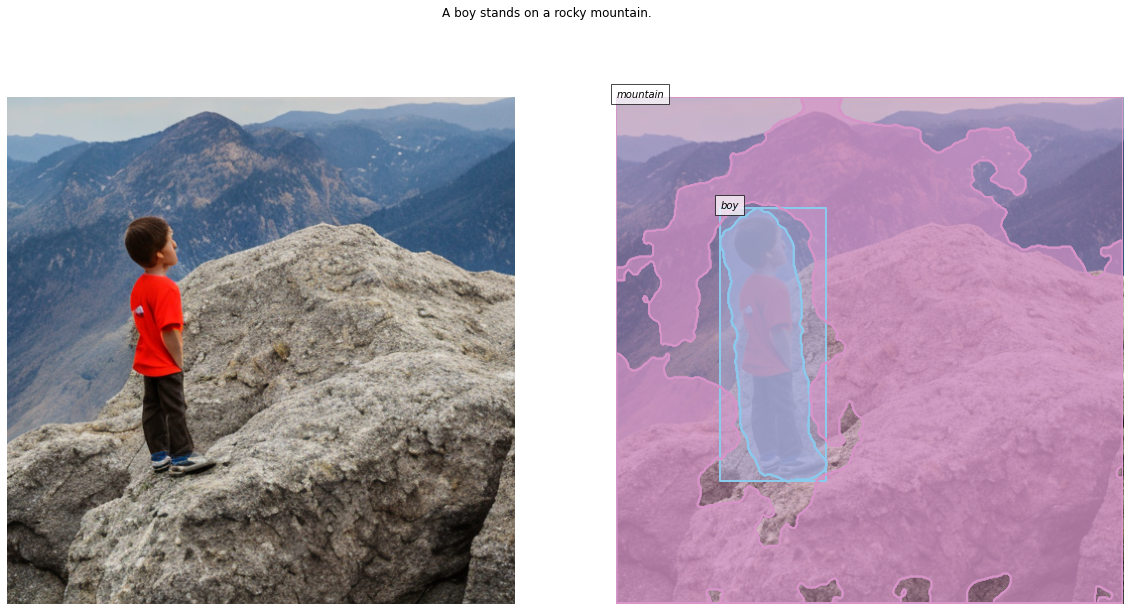

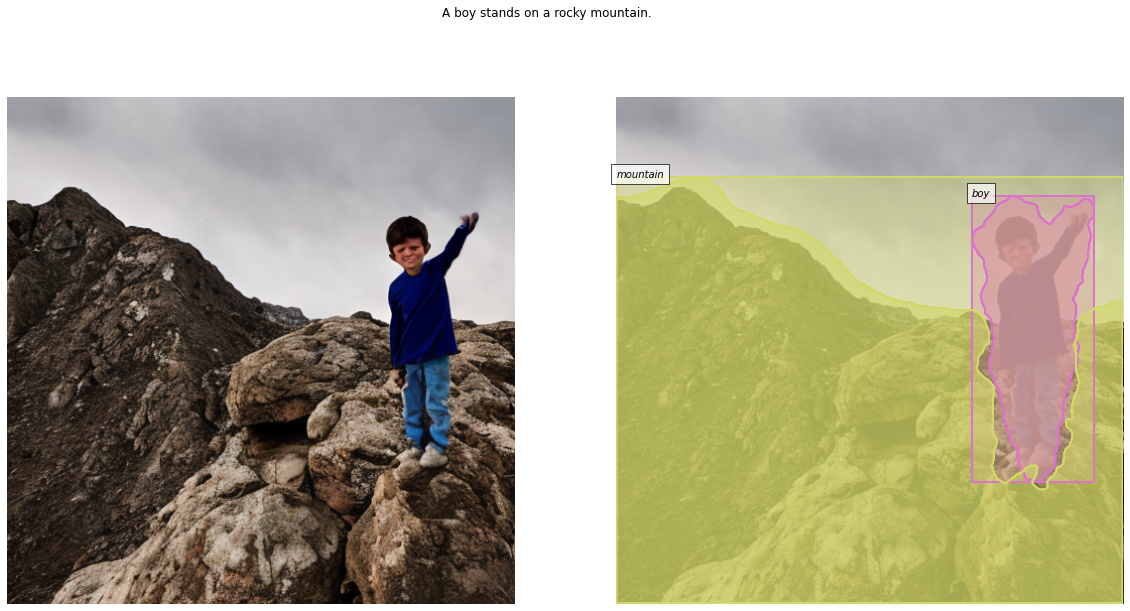

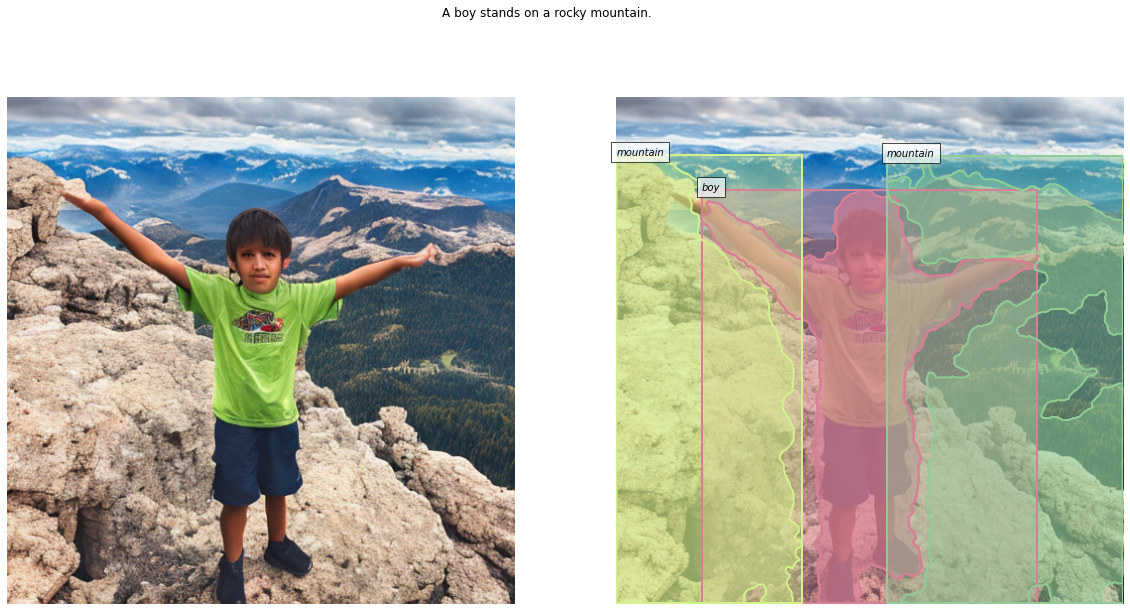

In [24]:
for i in range(1, NUM_IMAGES_PER_PROMPT * len(prompts)+1):
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

### CLIP Re-Ranking

Now, as we are generating `NUM_IMAGES_PER_PROMPT` many images for each caption. We might want to check the fidelity and quality of the generated images without manually scrutinizing each image. Thus, we use the powerful `CLIP` joint embedding model to see the similarity between the input caption and the generated image in the joint multi-modal space and we will rank the images based on that.

In [25]:
# We will store the rankings in a new folder under Data-Generated
os.mkdir('Data-Generated/rankings')

In [26]:
# Replace the name of the model with any of the models from clip.available_models() 
clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE) 

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 65.7MiB/s]


In [27]:
# Given the input of an image_id it finds the similarity score of that image with the caption which generated it
def clip_score_images(image_id): 

  # Load Image Details corresponding to the image_id
  try:
    img_info = coco_caption.loadImgs([image_id])[0]
    img_file_name = img_info['file_name']
  except KeyError:
    print(f'Image with ID: {image_id} is not present.')
    return 0

  # Load Caption Details corresponding to the image_id
  cap_ids = coco_caption.getAnnIds(imgIds=[image_id])
  cap = coco_caption.loadAnns(cap_ids)

  # Load Image corresponding to the image_id
  im = Image.open(os.path.join(image_dir, img_file_name))
  image = clip_preprocess(im).unsqueeze(0).to(DEVICE)
  text = clip.tokenize([cap[0]['caption']]).to(DEVICE)

  # Encode the image and text, pass it through the model and obtain score
  with torch.no_grad():
    logits_per_image, logits_per_text = clip_model(image, text) # Cosine similarity between the image and text feature vectors for similarity
    score = logits_per_image.item()

  # Return score
  return score

In [28]:
# Finds the list of image_ids generated by prompt at an index in ascending order of clip scores.
rankings = list()
print('Finding CLIP Ranking...')
for idx in tqdm(range(len(prompts))):
  ranking_det = {
      'prompt_id': idx + 1,
      'image_ids': NUM_IMAGES_PER_PROMPT * idx + 1 + np.argsort([clip_score_images(img_id) for img_id in range(NUM_IMAGES_PER_PROMPT * idx + 1, NUM_IMAGES_PER_PROMPT * (idx + 1) + 1)])
  }
  rankings.append(ranking_det)
print()
print('Done.')

Finding CLIP Ranking...


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Done.


In [29]:
# Creating the ranking file
ranking_file = {
    'info': info,
    'licenses': licenses,
    'prompts': [{'id': idx+1, 'text': prompts[idx]} for idx in range(len(prompts))],
    'images': annotation_file['images'],
    'rankings': rankings
}

In [30]:
# Saving annotations and captions when called -- mainly to avoid code repetition
# Serializing json
json_rank_det = json.dumps(ranking_file, indent=4, cls=NpEncoder)

# Writing json
with open(f"Data-Generated/rankings/rankings.json", "w") as outfile:
  outfile.write(json_rank_det)

print('Saved Ranking.. rankings.json')

# Delete json from python env
del json_rank_det

Saved Ranking.. rankings.json


In [31]:
# Loading the rankings.json file
with open('Data-Generated/rankings/rankings.json') as json_file:
  rank_file = json.load(json_file)

Below we see the re-ranked images displayed in ascending order of their ranking scores.

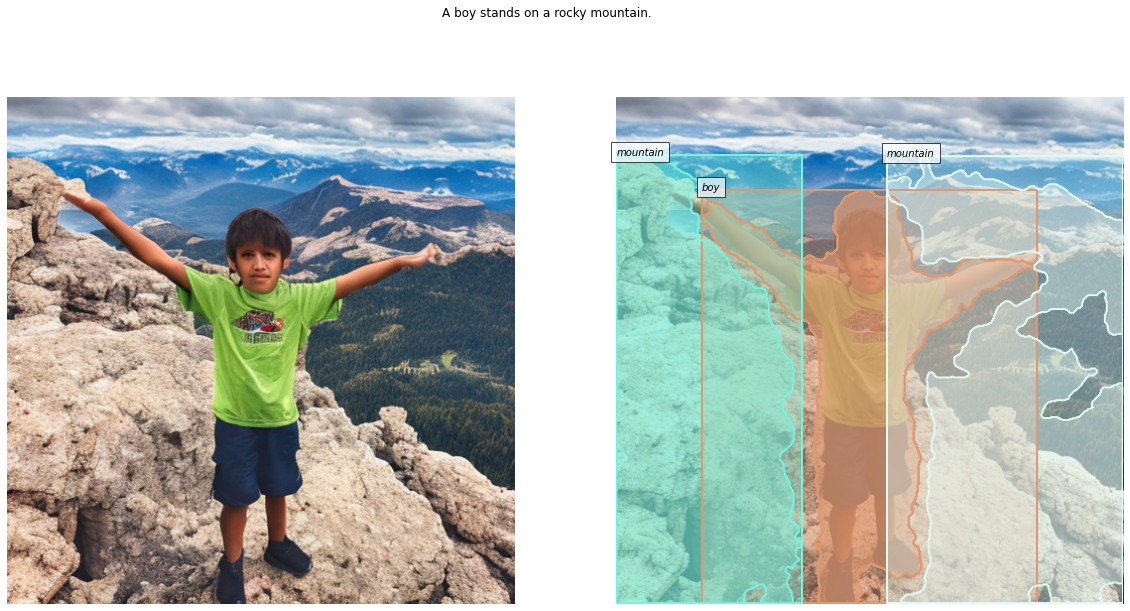

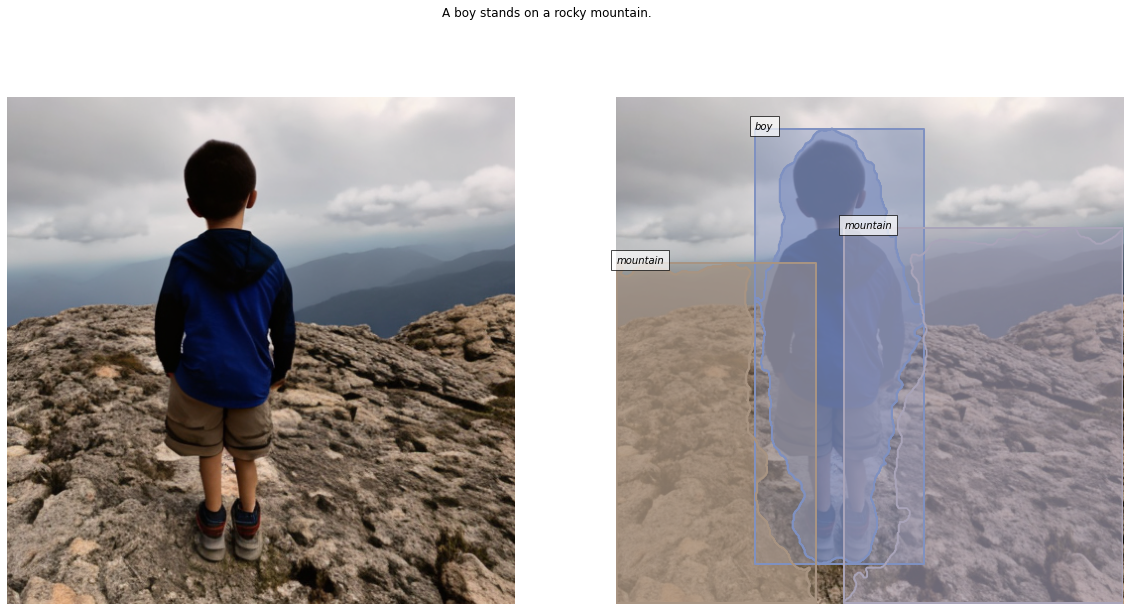

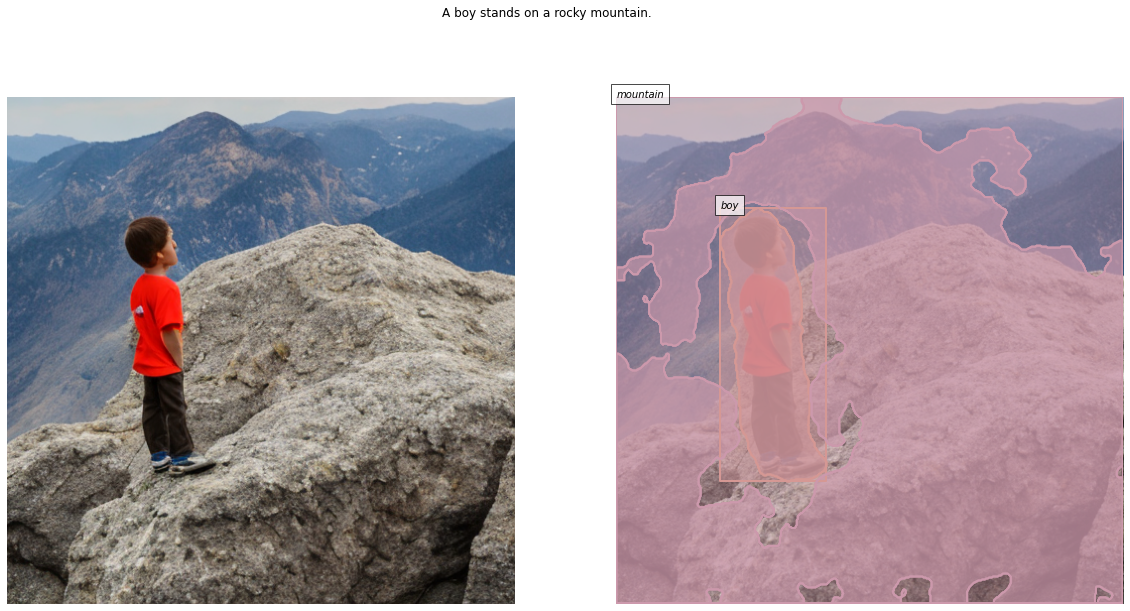

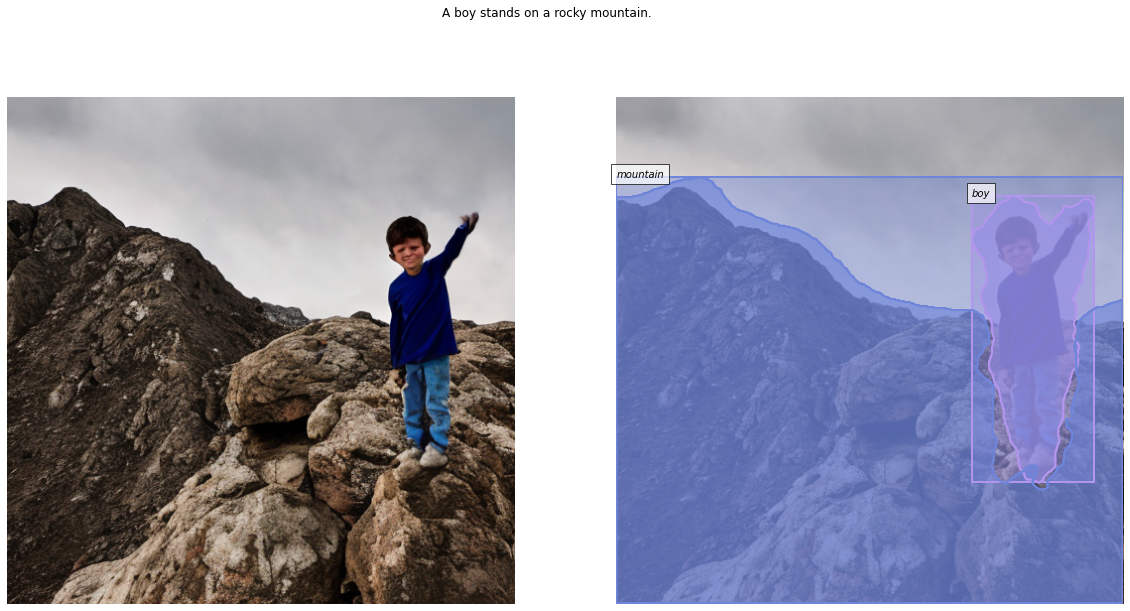

In [32]:
# Displaying the annotations and generated images based on CLIP ranking ordering
for prompt_id in range(1, len(prompts)+1):
  ranking_info = [rank for rank in rank_file['rankings'] if rank['prompt_id'] == prompt_id]
  for img_id in ranking_info[0]['image_ids']:
    try:
      visualize_annotation(img_id)
    except:
      print(f'Skipping {img_id}th image')